# Looking at histone-marker binding around the TSS of DEGs following depletion of Wapl

### Goals:

* investigate use of meta-seq for this purpose
* replicate extended data fig. 4: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7610352/figure/F10/?report=objectonly
* Think about improving modularity of generating various Chip-seq heat map analyses

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import bbi
from gffutils.helpers import asinterval
from gtfparse import read_gtf
import bioframe as bf
#import metaseq

## Step 1: Prepare project data

In [35]:
# data needed from experimental set-up to compare 
proj = "/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/pysradb_downloads/SRP216929/"

# sample 2 condition contains experimental set-up and helps describe the file structure of both kallisto mappings and DESeq results
s2c = pd.read_csv(proj+"s2c.tsv", index_col = 0, sep='\t')

In [36]:
# getting set of possible conditions from the sample 2 condition mapping
conditions = s2c['condition'].unique()

# formatting because dashes were removed when working in R
conditions = [x.strip().replace("-","_") for x in conditions]

# removing PT type for now (treating as a separate experiment)
conditions = [x for x in conditions if 'Wapl' in x ]

conditions

['Wapl_C20_96h', 'Wapl_C20_48h', 'Wapl_C20_24h', 'Wapl_C20_6h', 'Wapl_C20_0h']

## Step 2: DE Expression data preparation and TSS annotation

- import and format data from DE tables --> a dictionary with {conditions : results_table} 
- annotate the genes in the results table: add a TSS using bioframe

### 2.1 import and format data from DE tables --> a dictionary with {conditions : results_table}

In [37]:
# import DEseq results

# base condition
base_level='Wapl_C20_0h'

# Importing the .csv outputs from sleuth WT for each of the conditions into pandas dataframes:
deseq_results = {}

folder = proj+"deseq-mm10-results/"

for c in conditions:
    
    if c == base_level:
        continue
        
    df = pd.read_csv(folder+"pairwise_deseq_wt_"+c+".csv", index_col = 0)
    deseq_results[c] = df


In [38]:
# Now, can access the DE results for a dataset by it's name as dict key:
deseq_results['Wapl_C20_96h'].head(5)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSMUSG00000000001,1929.145607,-0.165139,0.126582,-1.304600,0.192029,0.359857
ENSMUSG00000000003,0.000000,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000000028,774.525472,-0.609255,0.176577,-3.450373,0.000560,0.003509
ENSMUSG00000000031,5.653012,0.144469,1.513693,0.095441,0.923964,NaN
ENSMUSG00000000037,18.294264,0.969905,0.905673,1.070922,0.284204,0.470906


### 2.2 Adding TSS annotation to each row in deseq_results

In [39]:
# Import TSS annotations

# Reading gtf file that contains only the parsed TSSes, generated from default gff_utils
tss_df = read_gtf('/project/fudenber_735/genomes/mm10/ensembl/tsses.gtf')

# cleaning out less-well defined chromosome numbers
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('NT_'))]
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('MT'))]

# paste 'chr' to all chromosome names
tss_df["seqname"] = 'chr' + tss_df["seqname"]

# rename column to chrom to match bedframe/bioframe format
tss_df = tss_df.rename(columns= {"seqname" : "chrom"})

/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'transcript_id', 'transcript_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'ccds_id']


In [40]:
# Removing pseudo chromosomes
before = len(tss_df)
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrGL'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrJH'))]
after = len(tss_df)

print("Removed " + str(before-after) + " rows.")

Removed 95 rows.


In [41]:
ts_intervals = tss_df[['gene_id','start', 'end']].drop_duplicates(['gene_id'])
ts_intervals.shape

(55364, 3)

In [42]:
# drop duplicate TSSes
ts_intervals = tss_df[['gene_id','chrom', 'start', 'end']].drop_duplicates(['gene_id'])

# add a TSS to each gene_id in all the results DFs
for k in deseq_results.keys():
    
    # drop gene from data field if there is no change associated
    deseq_results[k].dropna(subset=['log2FoldChange'], inplace=True)
    #deseq_results[k].set_index('gene_id', inplace=True)
    
    deseq_results[k] = deseq_results[k].merge(ts_intervals, left_index=True, right_on='gene_id', how='left')
    
    # Checking if any of the significant genes will be lost due to loss of TSS annotation
    print("Checking for 'lost' significant genes for condition: ", k)
    ix = np.where(deseq_results[k]['start'].isna() & (deseq_results[k]['padj'] < 0.05))
    print("lost: ", str(deseq_results[k].iloc[ix].shape[0]))
    
    # If could not find a TSS, drop entire row
    deseq_results[k].dropna(subset=['start'], inplace=True)

Checking for 'lost' significant genes for condition:  Wapl_C20_96h
lost:  34
Checking for 'lost' significant genes for condition:  Wapl_C20_48h
lost:  8
Checking for 'lost' significant genes for condition:  Wapl_C20_24h
lost:  1
Checking for 'lost' significant genes for condition:  Wapl_C20_6h
lost:  0


# TSS stack-up for H3K4me3 signal (promoter)

Note: organizationally, this one is different in that there is a different Chip-Seq file for each condition, rather than a different set of genes for each condition

In [43]:
# Load Chip-Seq files 
folder = "/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/chip-seq/"

hr_0 = "GSM3992915_19_WaplC6-0h_antiH3K4me3_sample_calibrated.bw"
hr_6 = "GSM3992916_20_WaplC6-6h_antiH3K4me3_sample_calibrated.bw"
hr_24 = "GSM3992917_21_WaplC6-24h_antiH3K4me3_sample_calibrated.bw"
hr_96 = "GSM3992918_22_WaplC6-96h_antiH3K4me3_sample_calibrated.bw"


In [44]:
conditions

['Wapl_C20_96h', 'Wapl_C20_48h', 'Wapl_C20_24h', 'Wapl_C20_6h', 'Wapl_C20_0h']

In [45]:
# We don't have a value for this one
DE_result_dict = deseq_results.pop('Wapl_C20_48h')

In [46]:
chip_seq_condition_dict = {'Wapl_C20_0h' : hr_0, 'Wapl_C20_6h' : hr_6,
                           'Wapl_C20_24h' : hr_24, 'Wapl_C20_96h' : hr_96}

In [14]:
# Using contents of deseq_degs_ctcf_binding to build average heatmap split by significance

### version 1: Replicating Extended Data Fig. 4

Average signal of H3K4me3 measured at different time points around the TSS of Differentially Expressed genes detected after 96 hours of WapL degradation

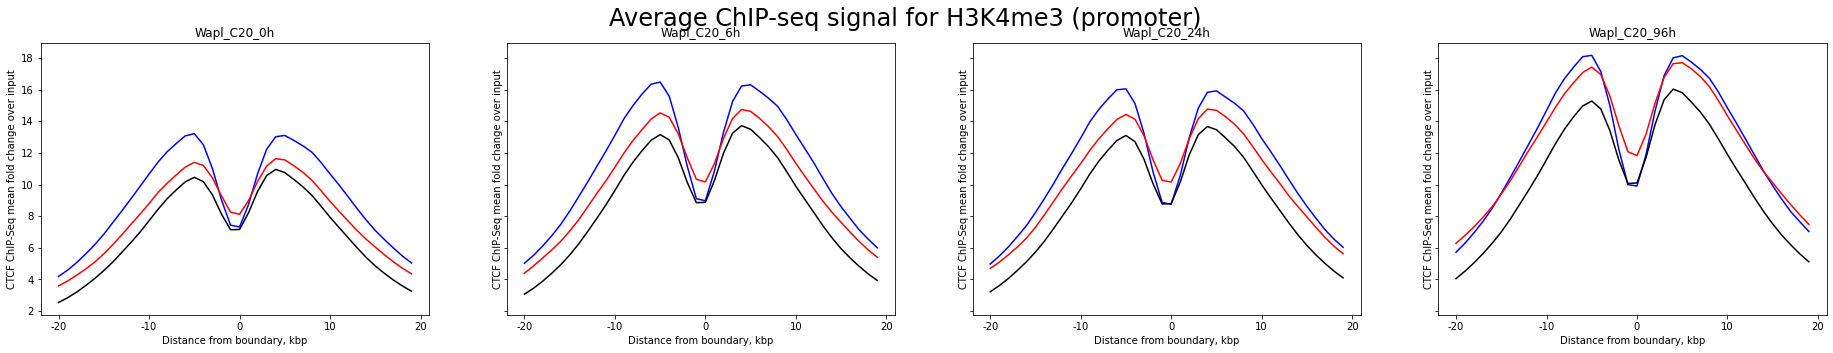

In [48]:
# Defining input components
figure_title = 'Average ChIP-seq signal for H3K4me3 (promoter)'
DE_result_dict = deseq_results
chip_seq_condition_dict = {'Wapl_C20_0h' : folder+hr_0, 'Wapl_C20_6h' : folder+hr_6,
                           'Wapl_C20_24h' : folder+hr_24, 'Wapl_C20_96h' : folder+hr_96}
interval_chrom = 'chrom' # can define custom columns (e.g. chrom_TSS)
interval_start = 'start'
interval_end = 'end'

# interval options:
extension = 1000
# others: center_interval --> finds middle, then can extend window from that middle

# cutoff
pval_cutoff = 0.05
cutoff_col = 'padj'

# some categorization (e.g. sig vs. non-sig, up-reg vs down-reg for grouping/coloring plots)
### not fleshed out --> maybe dict {'up' : "'log2FoldChange' > 0"}
categorization_col = 'log2Fold_Change'

# Getting plots ready
num_plots = len(chip_seq_condition_dict)
fig, ax = plt.subplots(1, num_plots, sharey=True, figsize=(8*num_plots, 5))
fig.suptitle(figure_title, fontsize=24)

i = 0

# Using only the DEGs detected after 96 hours for filtering on differentially expressed genes
DE_result_df = DE_result_dict['Wapl_C20_96h']

# Extracting significantly DE transcripts
sig_DE = DE_result_df[DE_result_df[cutoff_col] < pval_cutoff]
sig_DE_up = sig_DE[sig_DE['log2FoldChange'] > 0]
sig_DE_down = sig_DE[sig_DE['log2FoldChange'] <= 0]

# Will also look at enrichment around transcripts that were in RNAseq dataset that did not have significant DE
nonsig_DE = DE_result_df[DE_result_df['padj'] >= pval_cutoff] # include nonsig = True


for condition in chip_seq_condition_dict.keys():
    
    nbins = 40

    # initializing variables for pybbi matrices
    DE_up_matrix = None
    DE_down_matrix = None
    
    # chip_seq_file particular to the condition
    chip_seq_file = chip_seq_condition_dict[condition]

    # Generating summary of chip seq signal within the bins -1000 and +1000 from the TSS loc
    with bbi.open(chip_seq_file) as f:
        if not sig_DE_up.empty:
            DE_up_matrix = f.stackup(sig_DE_up[interval_chrom], sig_DE_up[interval_start] - extension, sig_DE_up[interval_end] + extension, bins=nbins)
        if not sig_DE_down.empty:
            DE_down_matrix = f.stackup(sig_DE_down[interval_chrom], sig_DE_down[interval_start] - extension, sig_DE_down[interval_end] + extension, bins=nbins)
        nonsig_DE_matrix = f.stackup(nonsig_DE[interval_chrom], nonsig_DE[interval_start] - extension, nonsig_DE[interval_end] + extension, bins=nbins)



    if (len(fig.axes) == 1):
        this_ax = ax
    else:
        this_ax = ax[i]

    if DE_down_matrix is not None:
        this_ax.plot(np.nanmean(DE_down_matrix, axis=0), color = 'b' )

    if DE_up_matrix is not None:
        this_ax.plot(np.nanmean(DE_up_matrix, axis=0), color = 'r' )

    this_ax.plot(np.nanmean(nonsig_DE_matrix, axis=0), color = 'k')

    this_ax.set(xticks=np.arange(0, nbins+1, 10),
           xticklabels=(np.arange(0, nbins+1, 10)-nbins//2),
           xlabel='Distance from boundary, kbp',
           ylabel='CTCF ChIP-Seq mean fold change over input')
    this_ax.set_title(condition)

    i+=1

### 1.2 heatmap (still plotting separately for now)

Extended data fig. 4: add heatmap of histone marker binding sorted by significant up- and down- regulated genes



number of significantly over-expressed:  1745
number of significantly under-expressed:  2025


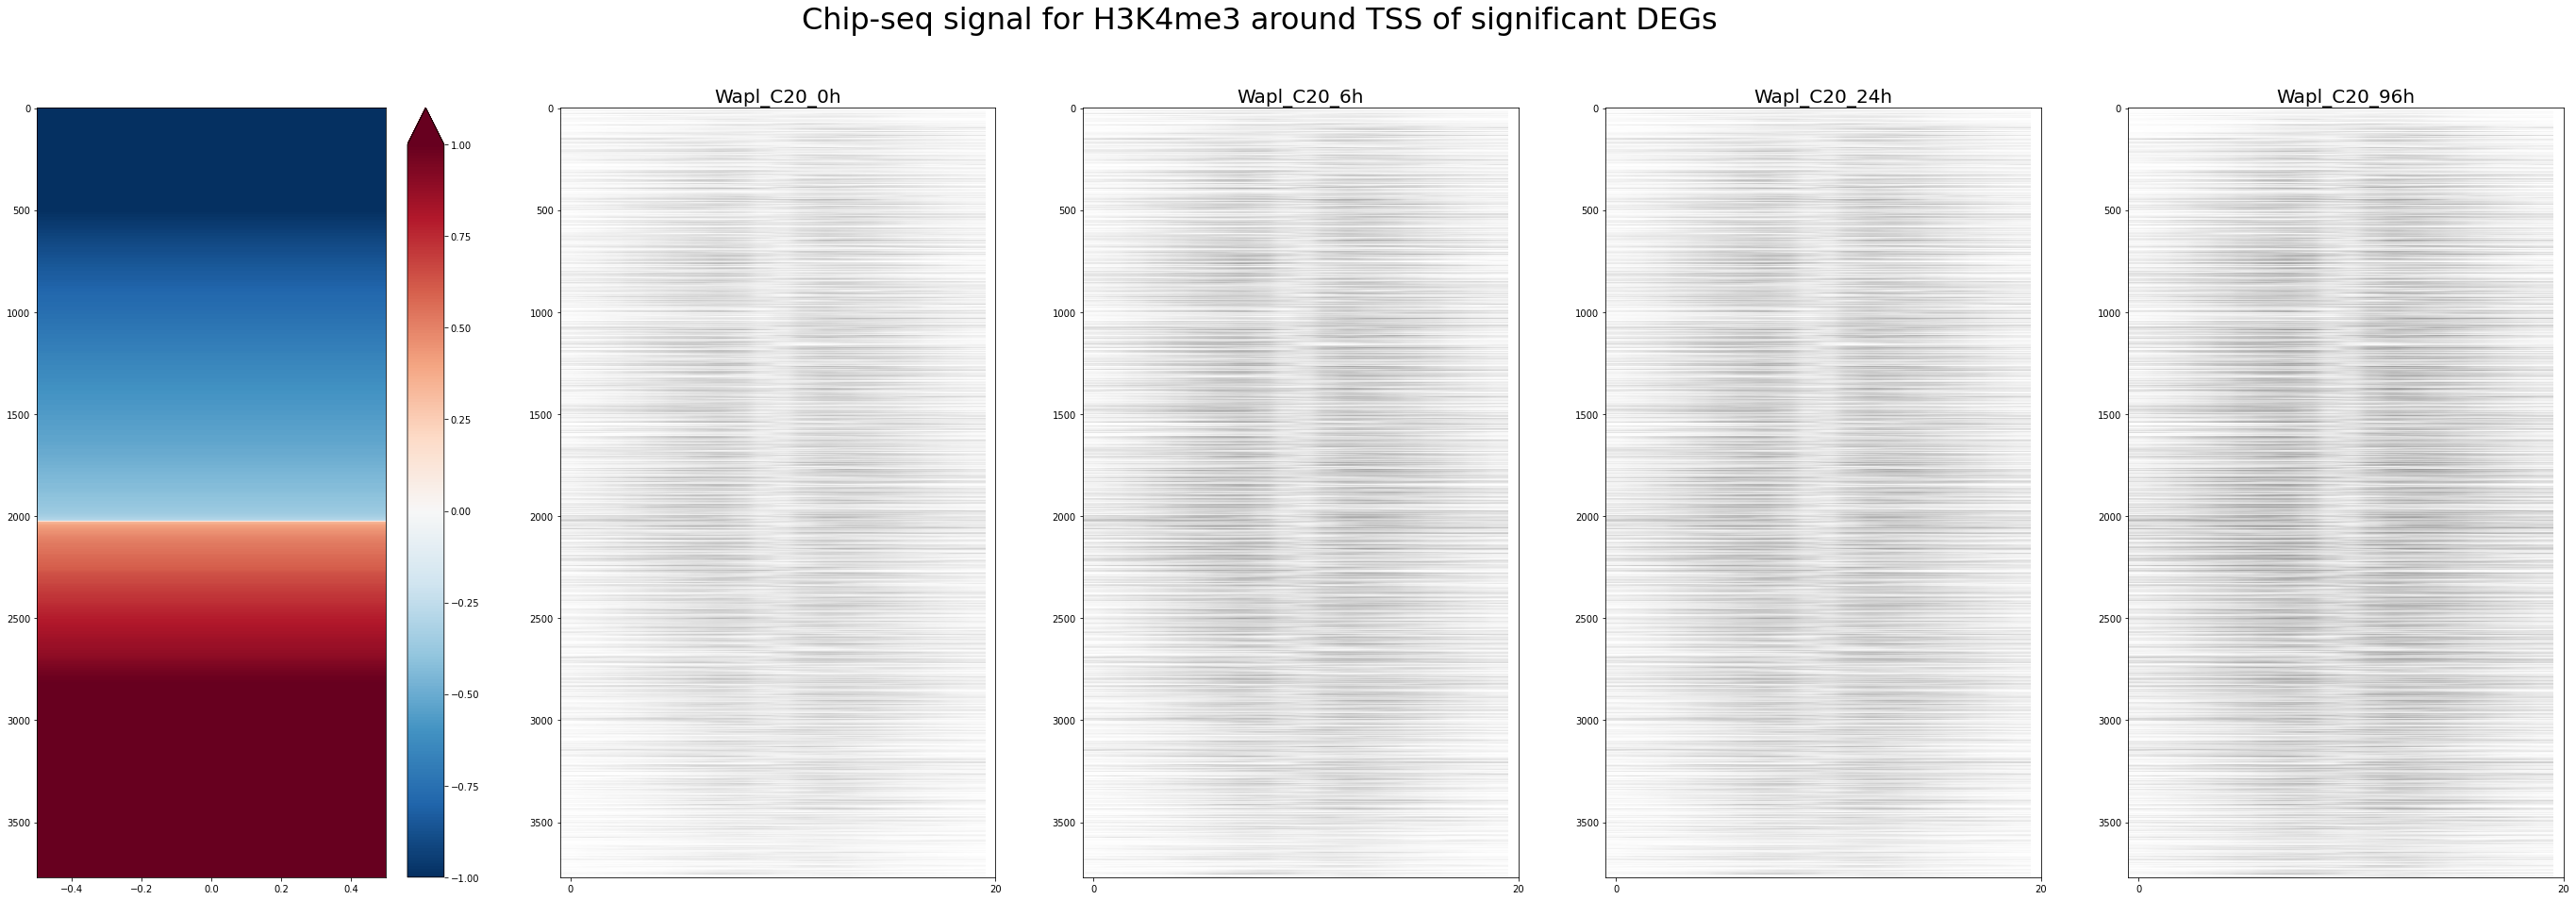

In [49]:
## finish this for H3K4me3 version
plot_title = "Chip-seq signal for H3K4me3 around TSS of significant DEGs" 

# Getting plots ready
num_conditions = len(chip_seq_condition_dict)
fig, ax = plt.subplots(1,num_conditions+1, figsize=(12*num_conditions, 15)) #only one colorbar
fig.suptitle(plot_title, fontsize=32)
i = 0

# Extracting significantly DE transcripts
sig_DE = DE_result_df[DE_result_df[cutoff_col] < pval_cutoff].sort_values(by='log2FoldChange')
sig_DE_up = sig_DE[sig_DE['log2FoldChange'] > 0]
sig_DE_down = sig_DE[sig_DE['log2FoldChange'] <= 0]

# I don't think we need to store/separate these two DFs ? delete if makes sense
print("number of significantly over-expressed: ", len(sig_DE_up))
print("number of significantly under-expressed: ", len(sig_DE_down))

# extracting the beta change vector
logFPKM = np.transpose(np.expand_dims(sig_DE['log2FoldChange'], axis=0))
minval=np.min(sig_DE_down['log2FoldChange'])
maxval=np.max(sig_DE_up['log2FoldChange'])

# Adding colorbar for this DE set
divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
hotcoldmap = plt.cm.get_cmap('RdBu').reversed()
occ = ax[i].imshow(logFPKM, cmap=hotcoldmap, norm=divnorm, aspect='auto')
cbar = ax[i].figure.colorbar(occ, ax=ax[i], extend='max')
i+=1


for condition, chip_seq_file in chip_seq_condition_dict.items():


    # Generating summary of chip seq signal within the bins -1000 and +1000 from the TSS loc
    with bbi.open(chip_seq_file) as f:
        #DE_matrix = f.stackup(window_df['chrom_TSS'], window_df['start_TSS'] - 1000, window_df['end_TSS'] + 1000, bins=20)

        DE_matrix = f.stackup(sig_DE['chrom'], sig_DE['start'] - 1000, sig_DE['end'] + 1000, bins=20)

    
    name = condition
    ax[i].set_title(name, fontsize=20)
    # Plotting ctcf binding
    fig = ax[i].imshow(DE_matrix, cmap='gray_r', aspect='auto', vmin=0, vmax=100)
    ax[i].set_xticks([0, 20])
    i+=1

plt.show()

### version 2: Looking at changes in chip-seq signal in the DEG set at each time point

average Chip-Seq signal of H3K4me3 for differentially expressed genes following WapL degradation

number of significantly over-expressed:  1745
number of significantly under-expressed:  2025
number of significantly over-expressed:  62
number of significantly under-expressed:  95
number of significantly over-expressed:  11
number of significantly under-expressed:  19


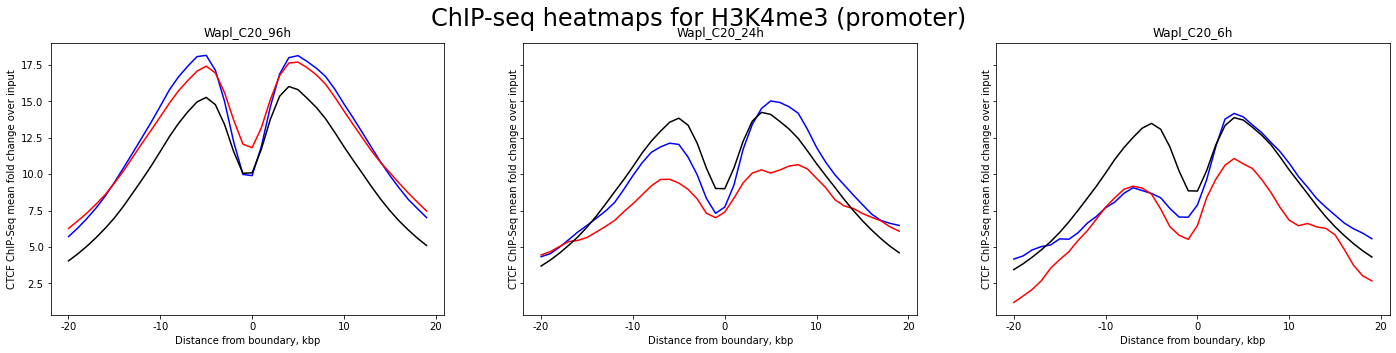

In [47]:
# Defining input components
figure_title = 'ChIP-seq heatmaps for H3K4me3 (promoter)'
DE_result_dict = deseq_results
chip_seq_condition_dict = {'Wapl_C20_0h' : folder+hr_0, 'Wapl_C20_6h' : folder+hr_6,
                           'Wapl_C20_24h' : folder+hr_24, 'Wapl_C20_96h' : folder+hr_96}
interval_chrom = 'chrom' # can define custom columns (e.g. chrom_TSS)
interval_start = 'start'
interval_end = 'end'

# interval options:
extension = 1000
# others: center_interval --> finds middle, then can extend window from that middle

# cutoff
pval_cutoff = 0.05
cutoff_col = 'padj'

# some categorization (e.g. sig vs. non-sig, up-reg vs down-reg for grouping/coloring plots)
### not fleshed out --> maybe dict {'up' : "'log2FoldChange' > 0"}
categorization_col = 'log2Fold_Change'

# Getting plots ready
num_plots = len(DE_result_dict)
fig, ax = plt.subplots(1, num_plots, sharey=True, figsize=(8*num_plots, 5))
fig.suptitle(figure_title, fontsize=24)

i = 0

for condition, DE_result_df in DE_result_dict.items():

    # Extracting significantly DE transcripts
    sig_DE = DE_result_df[DE_result_df[cutoff_col] < pval_cutoff]
    sig_DE_up = sig_DE[sig_DE['log2FoldChange'] > 0]
    sig_DE_down = sig_DE[sig_DE['log2FoldChange'] <= 0]
    
    # I don't think we need to store/separate these two DFs ? delete if makes sense
    print("number of significantly over-expressed: ", len(sig_DE_up))
    print("number of significantly under-expressed: ", len(sig_DE_down))

    # Will also look at enrichment around transcripts that were in RNAseq dataset that did not have significant DE
    nonsig_DE = DE_result_df[DE_result_df['padj'] >= pval_cutoff] # include nonsig = True

    nbins = 40

    # initializing variables for pybbi matrices
    DE_up_matrix = None
    DE_down_matrix = None
    
    # chip_seq_file particular to the condition
    chip_seq_file = chip_seq_condition_dict[condition]

    # Generating summary of chip seq signal within the bins -1000 and +1000 from the TSS loc
    with bbi.open(chip_seq_file) as f:
        if not sig_DE_up.empty:
            DE_up_matrix = f.stackup(sig_DE_up[interval_chrom], sig_DE_up[interval_start] - extension, sig_DE_up[interval_end] + extension, bins=nbins)
        if not sig_DE_down.empty:
            DE_down_matrix = f.stackup(sig_DE_down[interval_chrom], sig_DE_down[interval_start] - extension, sig_DE_down[interval_end] + extension, bins=nbins)
        nonsig_DE_matrix = f.stackup(nonsig_DE[interval_chrom], nonsig_DE[interval_start] - extension, nonsig_DE[interval_end] + extension, bins=nbins)



    if (len(fig.axes) == 1):
        this_ax = ax
    else:
        this_ax = ax[i]

    # 
    if DE_down_matrix is not None:
        this_ax.plot(np.nanmean(DE_down_matrix, axis=0), color = 'b' )

    if DE_up_matrix is not None:
        this_ax.plot(np.nanmean(DE_up_matrix, axis=0), color = 'r' )

    this_ax.plot(np.nanmean(nonsig_DE_matrix, axis=0), color = 'k')

    this_ax.set(xticks=np.arange(0, nbins+1, 10),
           xticklabels=(np.arange(0, nbins+1, 10)-nbins//2),
           xlabel='Distance from boundary, kbp',
           ylabel='CTCF ChIP-Seq mean fold change over input')
    this_ax.set_title(condition)

    i+=1

# H3K27ac (enhancer) signal around TSS of DEGS

In [58]:
# Load Chip-Seq files 
folder = "/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/chip-seq/"

hr_0 = "GSM3992919_23_WaplC6-0h_antiH3K27ac_sample_calibrated.bw"
hr_6 = "GSM3992920_24_WaplC6-6h_antiH3K27ac_sample_calibrated.bw"
hr_24 = "GSM3992921_25_WaplC6-24h_antiH3K27ac_sample_calibrated.bw"
hr_96 = "GSM3992922_26_WaplC6-96h_antiH3K27ac_sample_calibrated.bw"

file:  /project/fudenber_735/GEO/liu_deWit_2021_GSE135180/chip-seq/GSM3992919_23_WaplC6-0h_antiH3K27ac_sample_calibrated.bw
file:  /project/fudenber_735/GEO/liu_deWit_2021_GSE135180/chip-seq/GSM3992920_24_WaplC6-6h_antiH3K27ac_sample_calibrated.bw
file:  /project/fudenber_735/GEO/liu_deWit_2021_GSE135180/chip-seq/GSM3992921_25_WaplC6-24h_antiH3K27ac_sample_calibrated.bw
file:  /project/fudenber_735/GEO/liu_deWit_2021_GSE135180/chip-seq/GSM3992922_26_WaplC6-96h_antiH3K27ac_sample_calibrated.bw


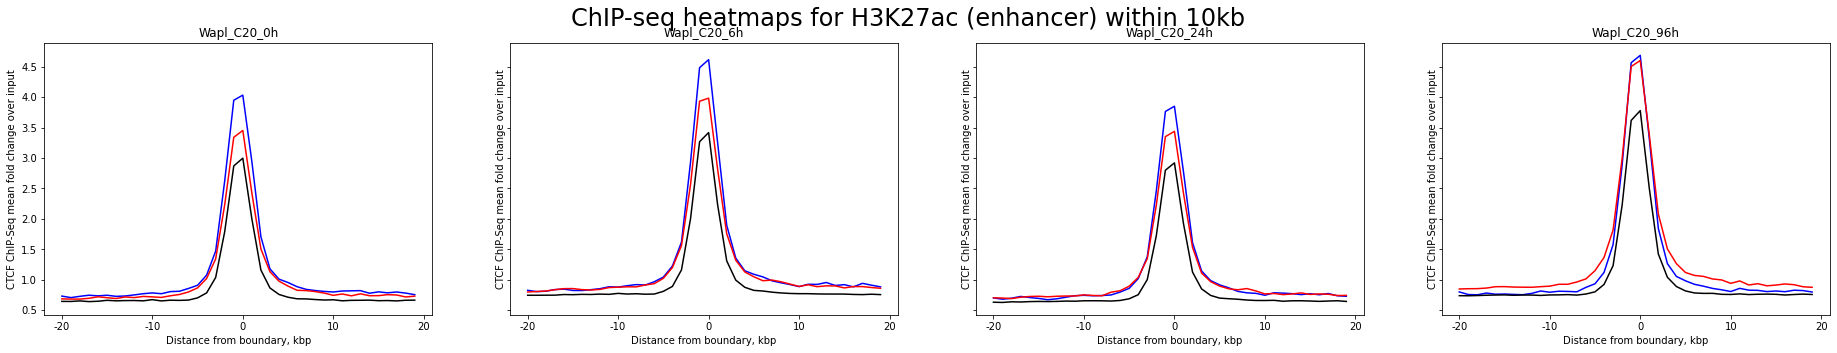

In [63]:
# Defining input components
figure_title = 'ChIP-seq heatmaps for H3K27ac (enhancer) within 10kb'
DE_result_dict = deseq_results
chip_seq_condition_dict = {'Wapl_C20_0h' : folder+hr_0, 'Wapl_C20_6h' : folder+hr_6,
                           'Wapl_C20_24h' : folder+hr_24, 'Wapl_C20_96h' : folder+hr_96}
interval_chrom = 'chrom' # can define custom columns (e.g. chrom_TSS)
interval_start = 'start'
interval_end = 'end'

# interval options:
extension = 10000
# others: center_interval --> finds middle, then can extend window from that middle

# cutoff
pval_cutoff = 0.05
cutoff_col = 'padj'

# some categorization (e.g. sig vs. non-sig, up-reg vs down-reg for grouping/coloring plots)
### not fleshed out --> maybe dict {'up' : "'log2FoldChange' > 0"}
categorization_col = 'log2Fold_Change'

# Getting plots ready
num_plots = len(chip_seq_condition_dict)
fig, ax = plt.subplots(1, num_plots, sharey=True, figsize=(8*num_plots, 5))
fig.suptitle(figure_title, fontsize=24)

i = 0

# Using only the DEGs detected after 96 hours for filtering on differentially expressed genes
DE_result_df = DE_result_dict['Wapl_C20_96h']

# Extracting significantly DE transcripts
sig_DE = DE_result_df[DE_result_df[cutoff_col] < pval_cutoff]
sig_DE_up = sig_DE[sig_DE['log2FoldChange'] > 0]
sig_DE_down = sig_DE[sig_DE['log2FoldChange'] <= 0]

# Will also look at enrichment around transcripts that were in RNAseq dataset that did not have significant DE
nonsig_DE = DE_result_df[DE_result_df['padj'] >= pval_cutoff] # include nonsig = True


for condition in chip_seq_condition_dict.keys():
    
    nbins = 40

    # initializing variables for pybbi matrices
    DE_up_matrix = None
    DE_down_matrix = None
    
    # chip_seq_file particular to the condition
    chip_seq_file = chip_seq_condition_dict[condition]
    print("file: ", chip_seq_file)

    # Generating summary of chip seq signal within the bins -1000 and +1000 from the TSS loc
    with bbi.open(chip_seq_file) as f:
        if not sig_DE_up.empty:
            DE_up_matrix = f.stackup(sig_DE_up[interval_chrom], sig_DE_up[interval_start] - extension, sig_DE_up[interval_end] + extension, bins=nbins)
        if not sig_DE_down.empty:
            DE_down_matrix = f.stackup(sig_DE_down[interval_chrom], sig_DE_down[interval_start] - extension, sig_DE_down[interval_end] + extension, bins=nbins)
        nonsig_DE_matrix = f.stackup(nonsig_DE[interval_chrom], nonsig_DE[interval_start] - extension, nonsig_DE[interval_end] + extension, bins=nbins)



    if (len(fig.axes) == 1):
        this_ax = ax
    else:
        this_ax = ax[i]

    if DE_down_matrix is not None:
        this_ax.plot(np.nanmean(DE_down_matrix, axis=0), color = 'b' )

    if DE_up_matrix is not None:
        this_ax.plot(np.nanmean(DE_up_matrix, axis=0), color = 'r' )

    this_ax.plot(np.nanmean(nonsig_DE_matrix, axis=0), color = 'k')

    this_ax.set(xticks=np.arange(0, nbins+1, 10),
           xticklabels=(np.arange(0, nbins+1, 10)-nbins//2),
           xlabel='Distance from boundary, kbp',
           ylabel='CTCF ChIP-Seq mean fold change over input')
    this_ax.set_title(condition)

    i+=1

number of significantly over-expressed:  1745
number of significantly under-expressed:  2025


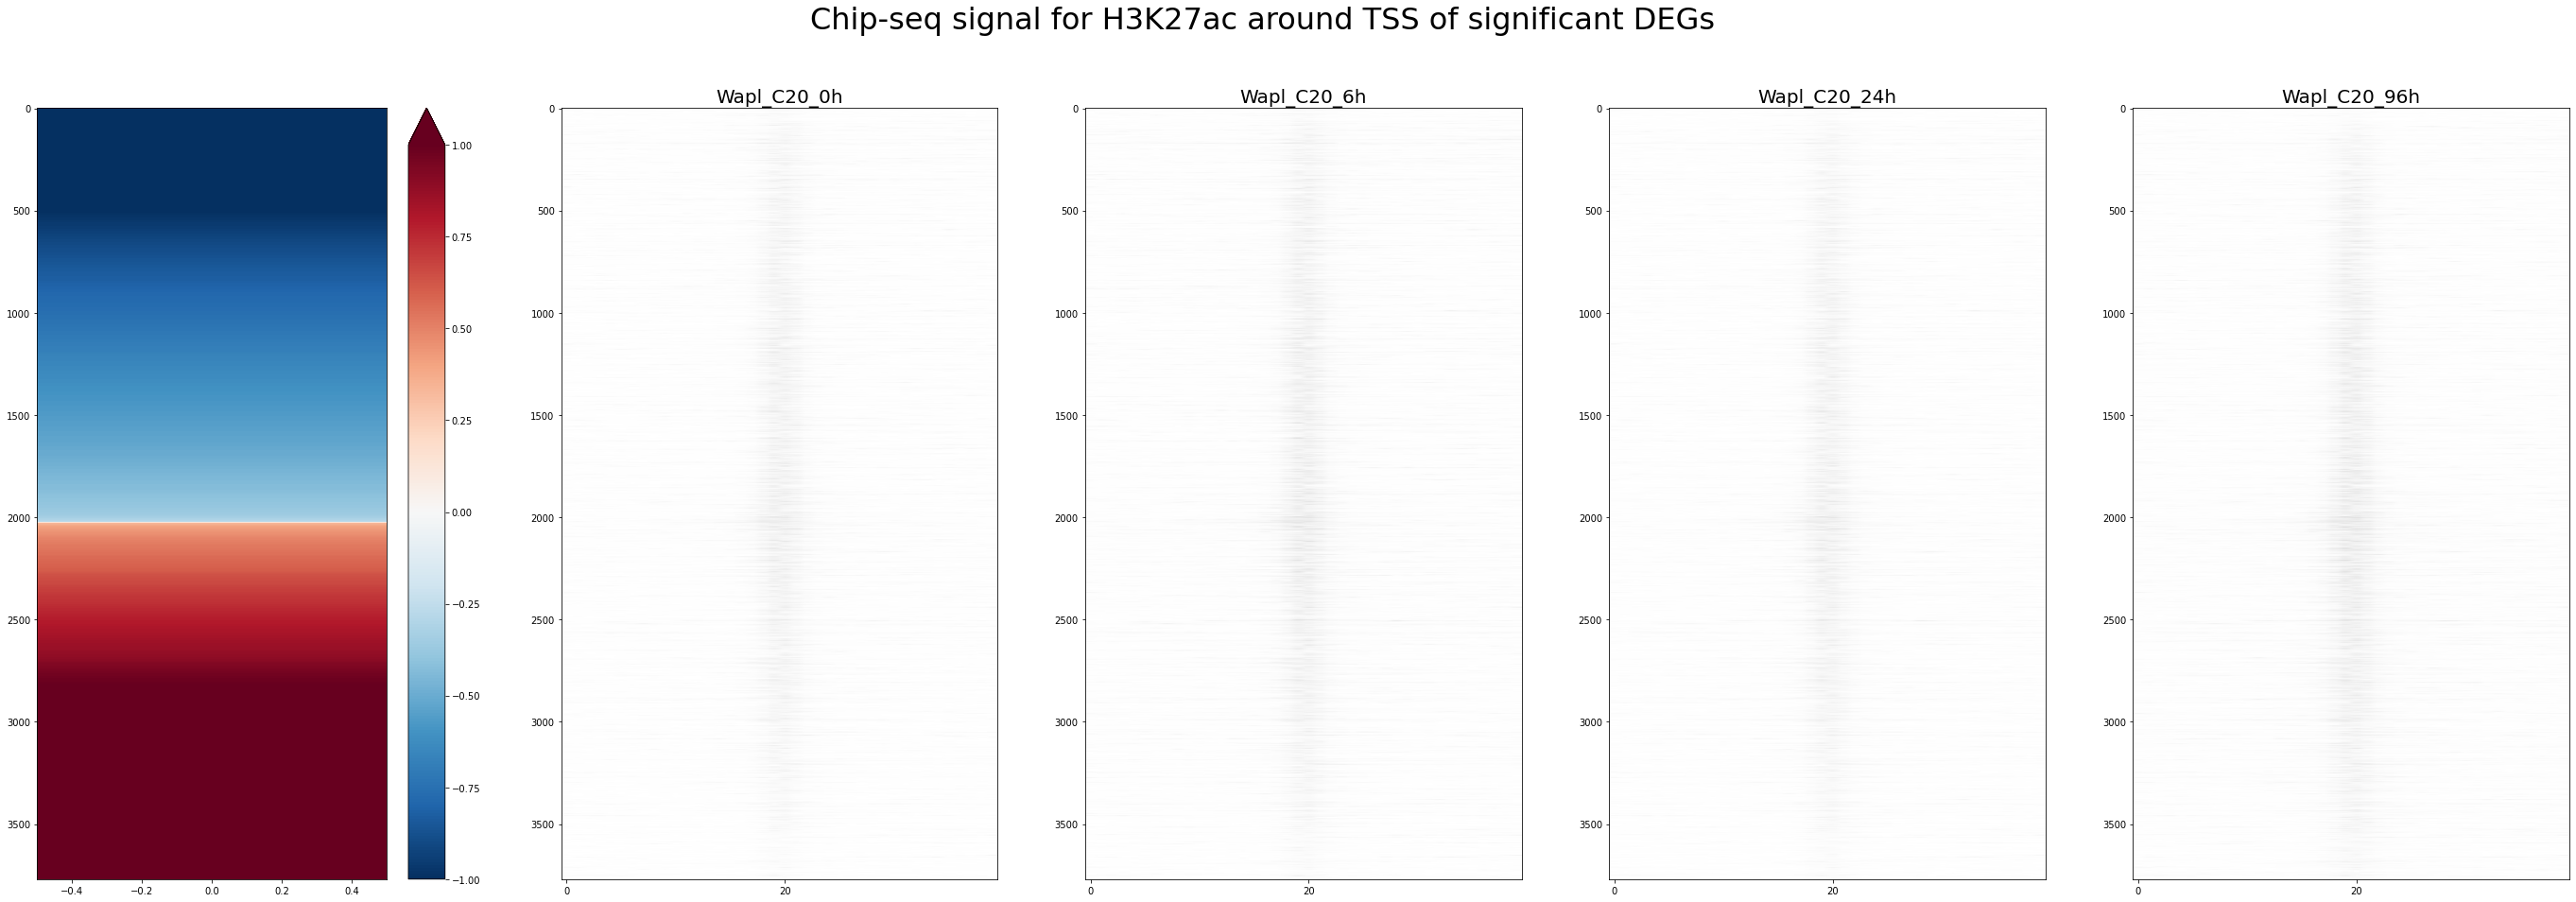

In [62]:
## finish this for H3K4me3 version
plot_title = "Chip-seq signal for H3K27ac around TSS of significant DEGs" 

# Getting plots ready
num_conditions = len(chip_seq_condition_dict)
fig, ax = plt.subplots(1,num_conditions+1, figsize=(12*num_conditions, 15)) #only one colorbar
fig.suptitle(plot_title, fontsize=32)
i = 0

# Extracting significantly DE transcripts
sig_DE = DE_result_df[DE_result_df[cutoff_col] < pval_cutoff].sort_values(by='log2FoldChange')
sig_DE_up = sig_DE[sig_DE['log2FoldChange'] > 0]
sig_DE_down = sig_DE[sig_DE['log2FoldChange'] <= 0]

# I don't think we need to store/separate these two DFs ? delete if makes sense
print("number of significantly over-expressed: ", len(sig_DE_up))
print("number of significantly under-expressed: ", len(sig_DE_down))

# extracting the beta change vector
logFPKM = np.transpose(np.expand_dims(sig_DE['log2FoldChange'], axis=0))
minval=np.min(sig_DE_down['log2FoldChange'])
maxval=np.max(sig_DE_up['log2FoldChange'])

# Adding colorbar for this DE set
divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
hotcoldmap = plt.cm.get_cmap('RdBu').reversed()
occ = ax[i].imshow(logFPKM, cmap=hotcoldmap, norm=divnorm, aspect='auto')
cbar = ax[i].figure.colorbar(occ, ax=ax[i], extend='max')
i+=1


for condition, chip_seq_file in chip_seq_condition_dict.items():


    # Generating summary of chip seq signal within the bins -1000 and +1000 from the TSS loc
    with bbi.open(chip_seq_file) as f:
        #DE_matrix = f.stackup(window_df['chrom_TSS'], window_df['start_TSS'] - 1000, window_df['end_TSS'] + 1000, bins=20)

        DE_matrix = f.stackup(sig_DE['chrom'], sig_DE['start'] - extension, sig_DE['end'] + extension, bins=40)

    
    name = condition
    ax[i].set_title(name, fontsize=20)
    # Plotting ctcf binding
    fig = ax[i].imshow(DE_matrix, cmap='gray_r', aspect='auto', vmin=0, vmax=100)
    ax[i].set_xticks([0, 20])
    i+=1

plt.show()

In [22]:
plot_deseq_CTCF_binding_together(basic_deseq_results,
                                 tss_df,
                                 chip_seq_file,
                                 pval_cutoff,
                                 "CTCF binding at the TSS of DEGs detected by DESeq2")

NameError: name 'plot_deseq_CTCF_binding_together' is not defined

==== General percentages for Condition : Wapl_C20_96h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 3804
Number of DE transcripts with an annotated TSS: 3770
Number of up-regulated genes: 1745
Number of down-regulated genes: 2025

==== General percentages for Condition : Wapl_C20_48h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 786
Number of DE transcripts with an annotated TSS: 778
Number of up-regulated genes: 312
Number of down-regulated genes: 466

==== General percentages for Condition : Wapl_C20_24h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 158
Number of DE transcripts with an annotated TSS: 157
Number of up-regulated genes: 62
Number of down-regulated genes: 95

==== General percentages for Condition : Wapl_C20_6h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 30
Number of DE transcripts with an annotated TSS: 30
Number of up-regulated genes: 11
Number of d

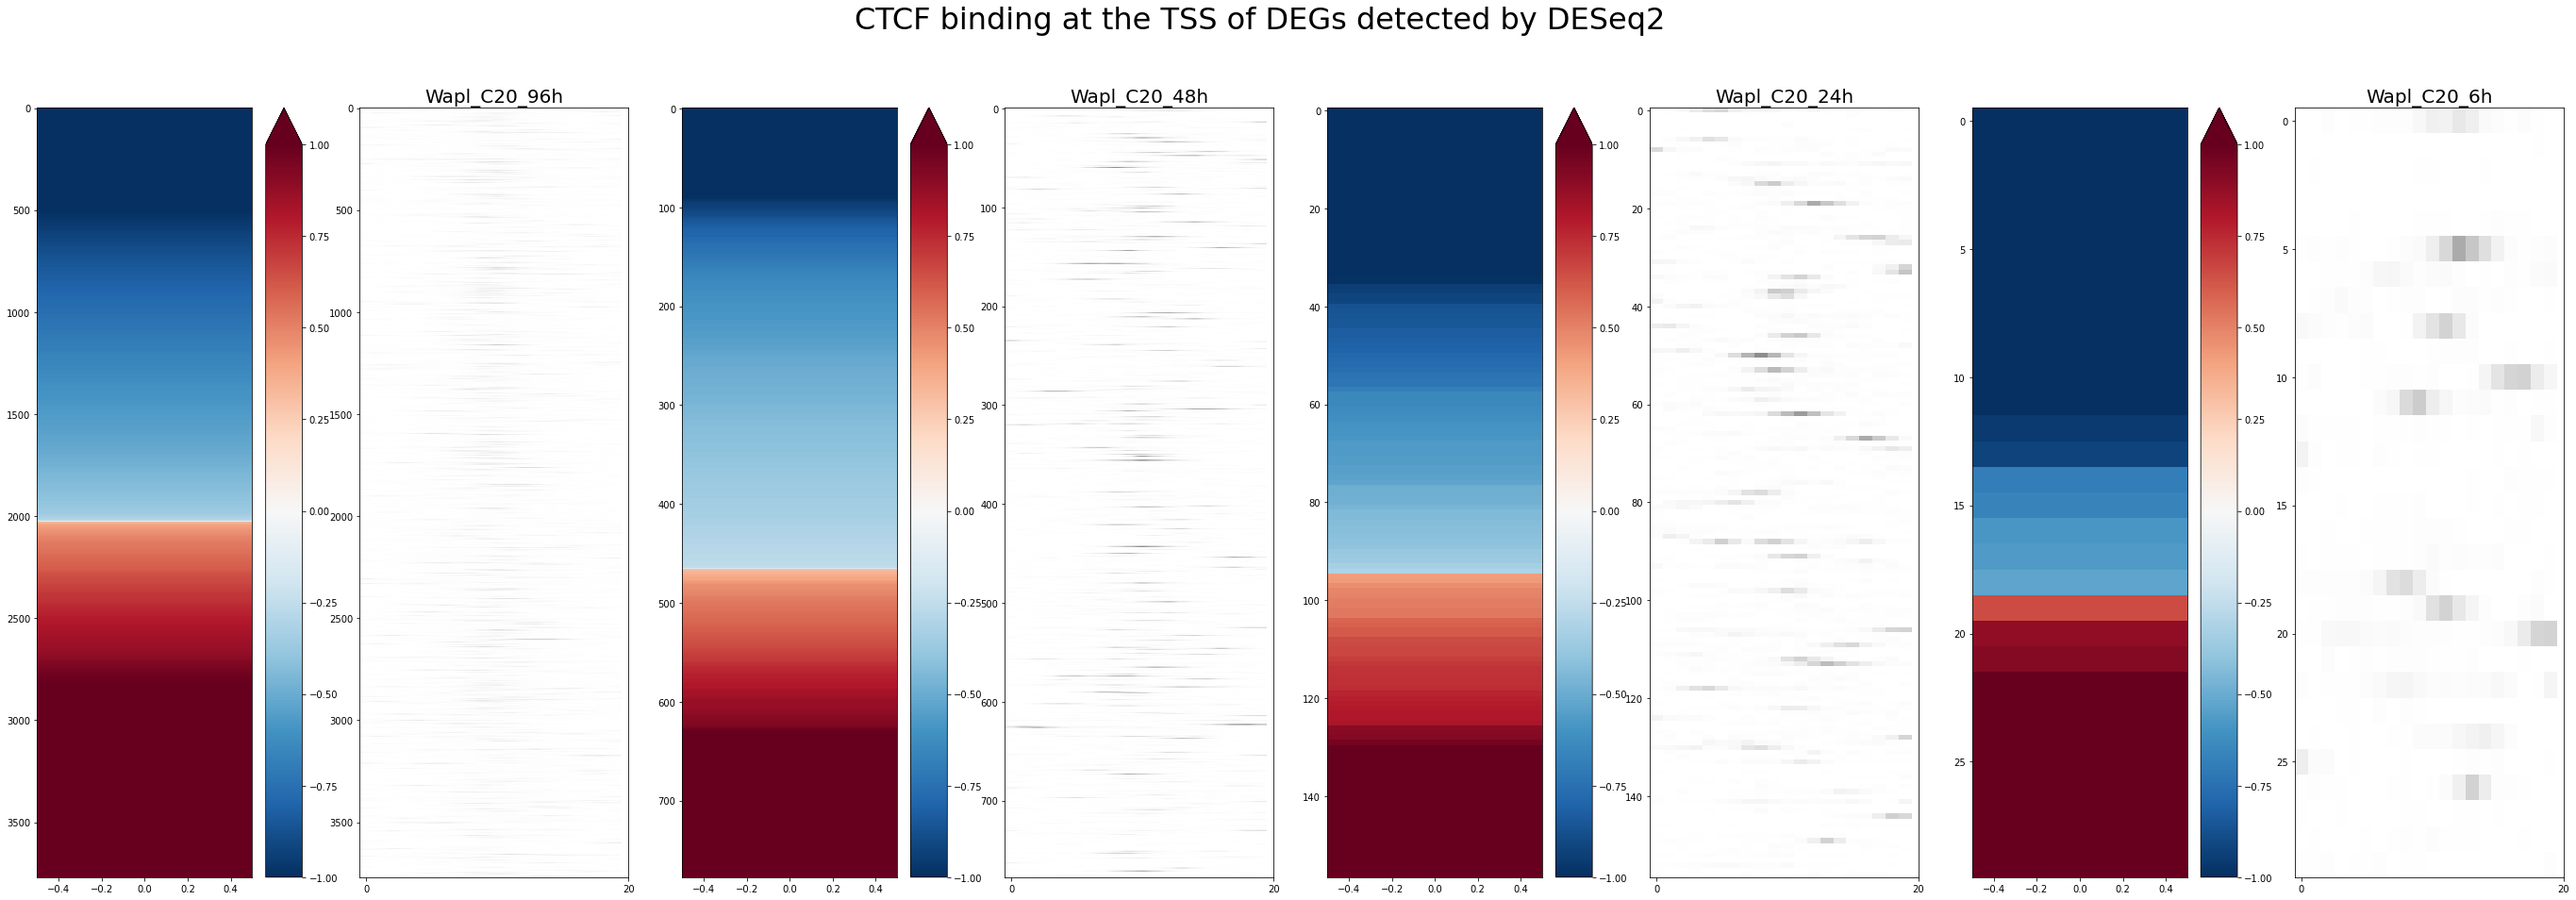

In [39]:
# Using another ChiP-seq file
chip_seq_file_RSC22 = "/project/fudenber_735/collaborations/karissa_2022/RNAseq/features/mm10/E14_CTCF/RSC22_E14_CTCF.scale.bw"

plot_deseq_CTCF_binding_together(basic_deseq_results, 
                                 tss_df,
                                 chip_seq_file_RSC22,
                                 pval_cutoff,
                                 "CTCF binding at the TSS of DEGs detected by DESeq2")

Signal is even lower than RSC13 -- will ditch this one

==== General percentages for Condition : Wapl_C20_96h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 3804
Number of DE transcripts with an annotated TSS: 3770
Number of up-regulated genes: 1745
Number of down-regulated genes: 2025

==== General percentages for Condition : Wapl_C20_48h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 786
Number of DE transcripts with an annotated TSS: 778
Number of up-regulated genes: 312
Number of down-regulated genes: 466

==== General percentages for Condition : Wapl_C20_24h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 158
Number of DE transcripts with an annotated TSS: 157
Number of up-regulated genes: 62
Number of down-regulated genes: 95

==== General percentages for Condition : Wapl_C20_6h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 30
Number of DE transcripts with an annotated TSS: 30
Number of up-regulated genes: 11
Number of d

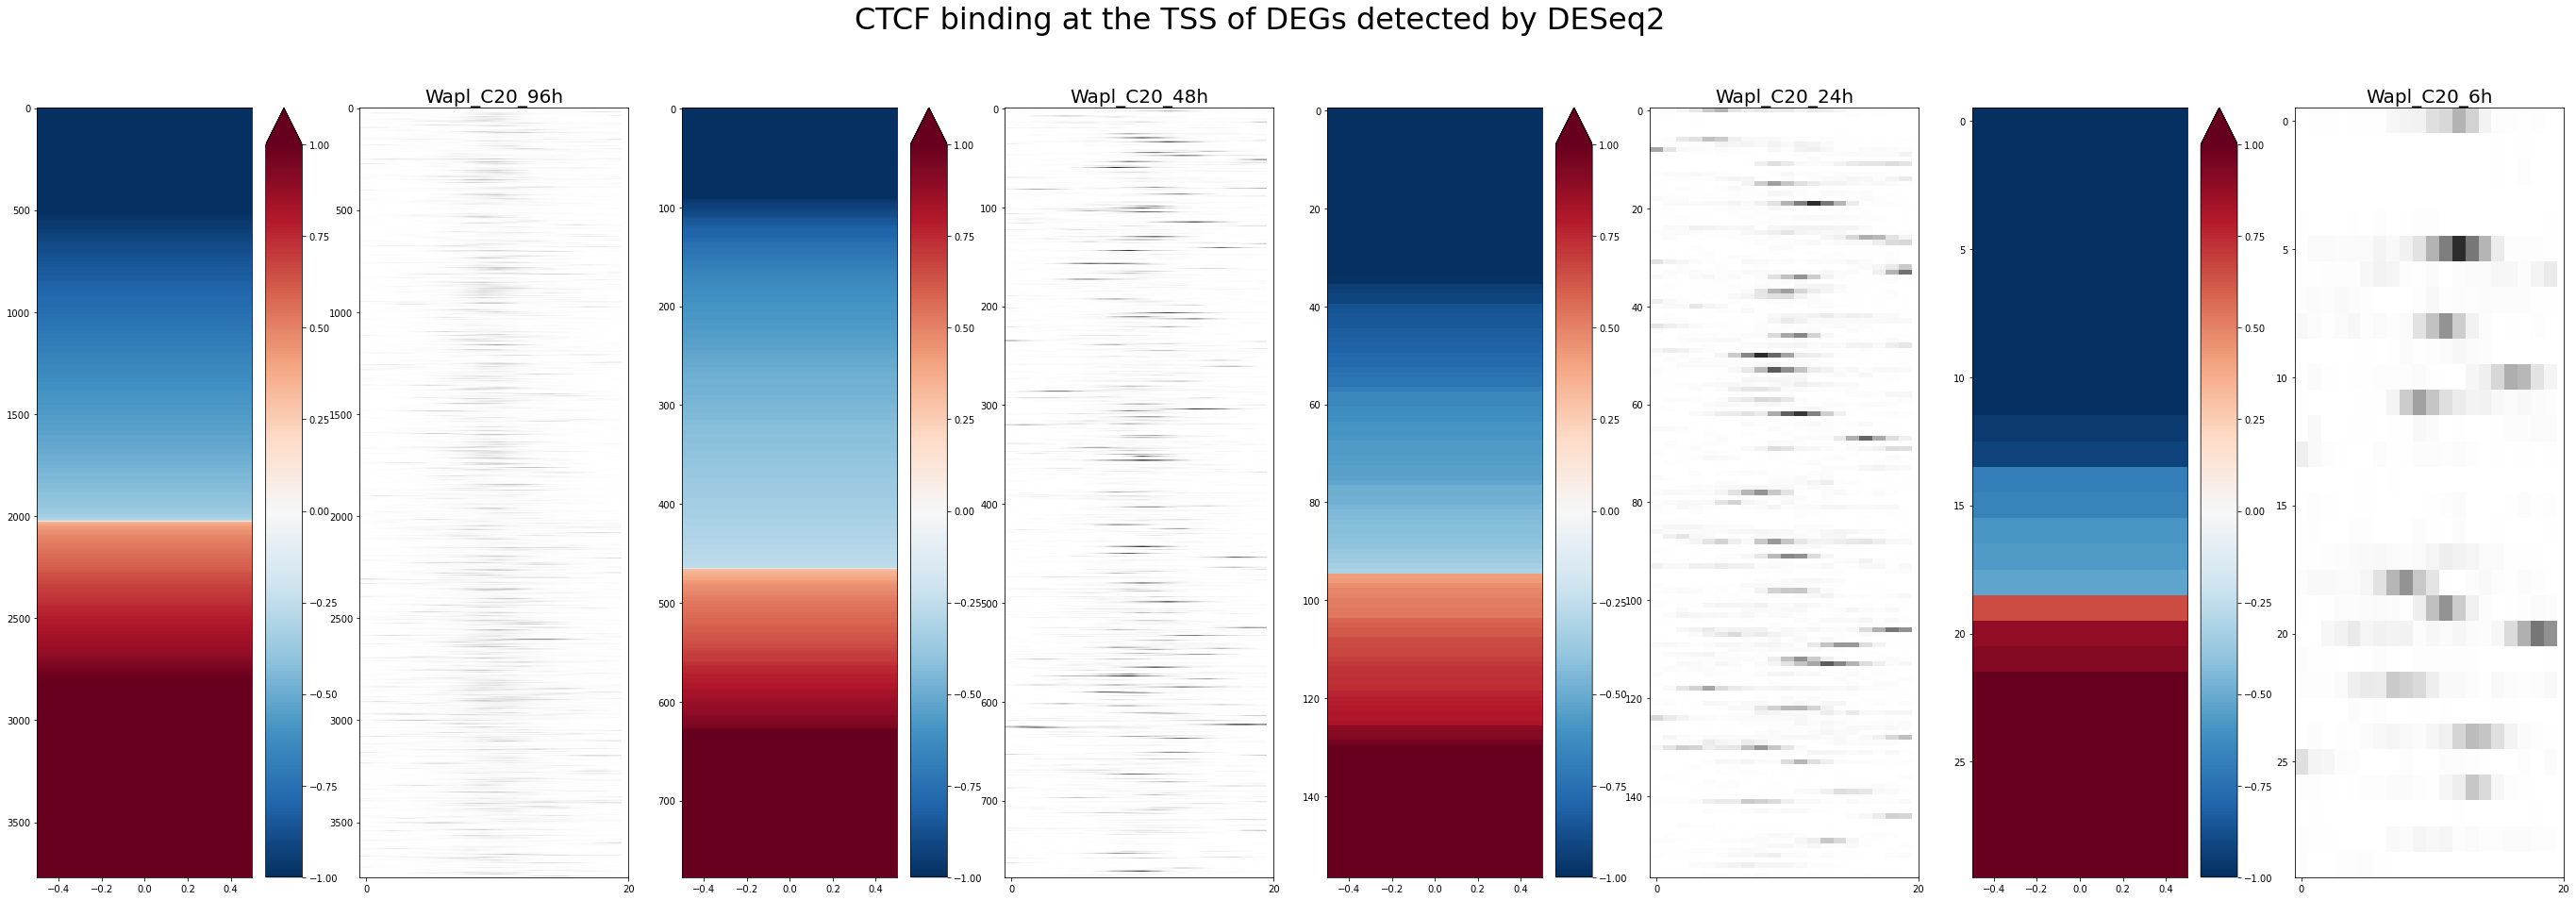

In [38]:
# Using yet another ChiP-seq file -- not sure we got an explanation of this one
chip_seq_file_RSC22 = "/project/fudenber_735/collaborations/karissa_2022/RNAseq/features/mm10/E14_CTCF/RSC37_E14_CTCF.scale.bw"

plot_deseq_CTCF_binding_together(basic_deseq_results, 
                                 tss_df,
                                 chip_seq_file_RSC22,
                                 pval_cutoff,
                                 "CTCF binding at the TSS of DEGs detected by DESeq2")

Looks the same at RSC13. Seems like RSC13 is the best, so I'll continue with that one until we either get a merged signal version or maybe liftover from mm9?

### Notes/Observations


```
"I had resequenced RSC12 and RSC13 to get more reads. Got good number of reads for RSC12 (which is Rad21 ChIP). RSC13 (CTCF ChIP) is also good but still fewer reads than I was aiming for. And hence these samples which were sequenced again are called new_scale (edited).
I need to merge my previous and the new RSC13 fastq files so that overall there are more reads when combined together and remap. Nevertheless, the ChIP quality is decent. Will be doing the merge and remap it soon and share.
Have generated the bw files for the input. Will just view them on the browser once and share." 
```

## ChiP-Seq file from Justice_2020:

Just to compare to another version that showed stronger signal when recapitulating dCTCF results (see TSS_heatmaps_mm10.ipynb)

==== General percentages for Condition : Wapl_C20_96h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 3804
Number of DE transcripts with an annotated TSS: 3770
Number of up-regulated genes: 1745
Number of down-regulated genes: 2025

==== General percentages for Condition : Wapl_C20_48h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 786
Number of DE transcripts with an annotated TSS: 778
Number of up-regulated genes: 312
Number of down-regulated genes: 466

==== General percentages for Condition : Wapl_C20_24h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 158
Number of DE transcripts with an annotated TSS: 157
Number of up-regulated genes: 62
Number of down-regulated genes: 95

==== General percentages for Condition : Wapl_C20_6h====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 30
Number of DE transcripts with an annotated TSS: 30
Number of up-regulated genes: 11
Number of d

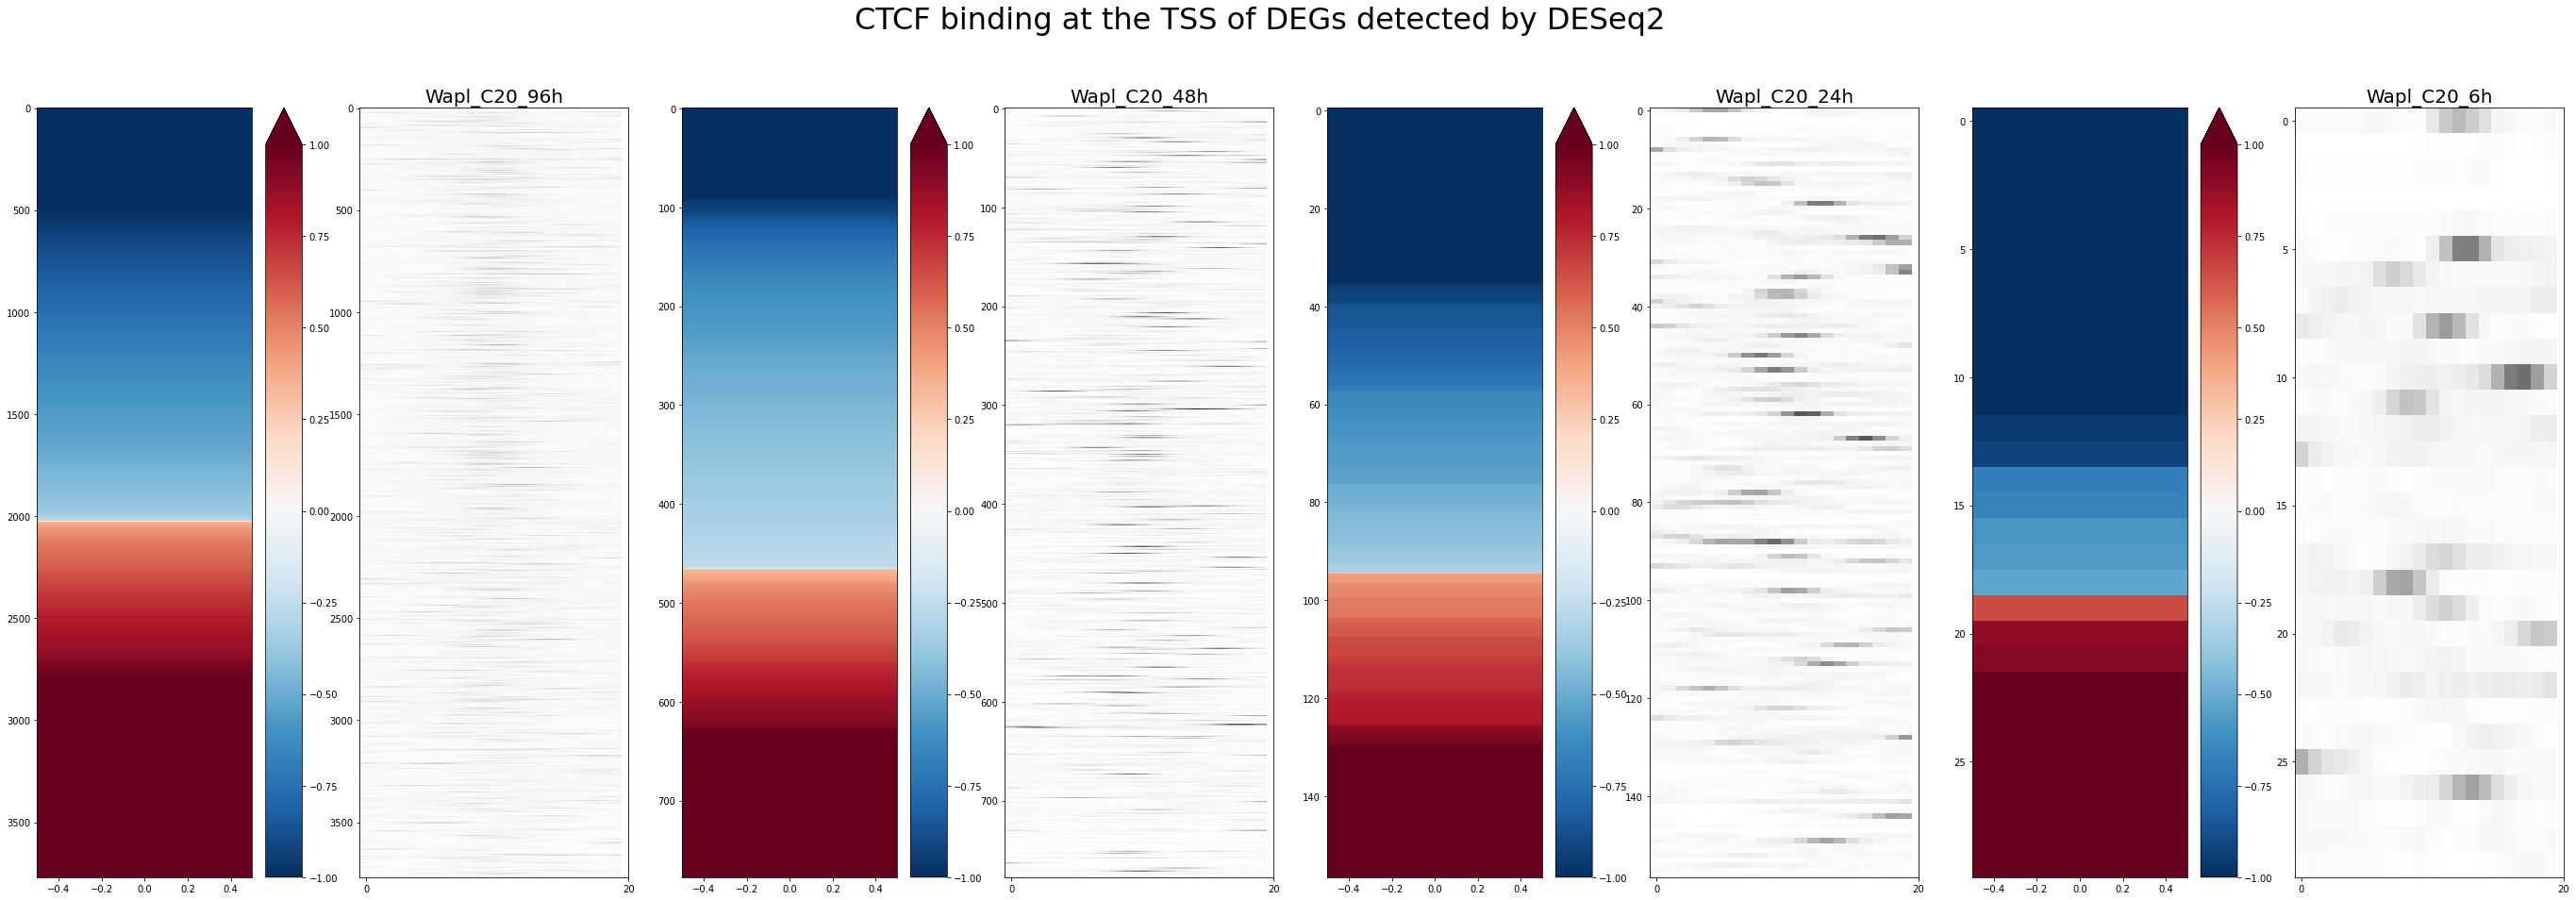

In [40]:
chip_seq_file_justice = "/project/fudenber_735/GEO/justice_2020_GSE137272/mm10/GSE137272_CTCF-ChIPseq.bw"

plot_deseq_CTCF_binding_together(basic_deseq_results, 
                                 tss_df,
                                 chip_seq_file_justice,
                                 pval_cutoff,
                                 "CTCF binding at the TSS of DEGs detected by DESeq2")

# CTCF Binding at TSS of DEGs following depletion of Nipbl: find in TSS_heatmaps_mm10.ipynb 

***Note:*** functions were developed in TSS_heatmaps_mm10.ipynb 

# Graphing functions: (essentially taken from TSS_headmaps_deseq.ipynb)

In [28]:
## To average CTCF signal for up-regulated vs down-regulated genes
def deseq_degs_ctcf_binding(DE_result_dict, figure_title, pval_cutoff, chip_seq_file):

    # Getting plots ready
    num_plots = len(DE_result_dict)
    fig, ax = plt.subplots(1, num_plots, sharey=True, figsize=(8*num_plots, 5))
    fig.suptitle(figure_title, fontsize=24)
    i = 0

    for condition, DE_result_df in DE_result_dict.items():

        
        # # lookup the TSS for this set of transcripts -- when result table not indexed by gene id
        # DE_results_TSS = DE_result_df.merge(tss_df.drop_duplicates(['gene_id']), how='inner', on='gene_id', suffixes=("_DEG", "_TSS"))
        
        # lookup TSS for this set of transcripts
        DE_results_TSS = DE_result_df.merge(tss_df.drop_duplicates(['gene_id']), left_index=True, right_on='gene_id')
        

        # how many did not have a transcript/were dropped?
        ni = len(DE_result_df)
        ntss = len(DE_results_TSS)
        print("Out of " + str(ni) + " transcripts from the sleuth output results, " + str(ntss) + " had corresponding TSS from ensembl GTF files.")
        print("Lost " + str(ni-ntss) + " transcripts for this analysis.")

        # Extracting significantly DE transcripts
        sig_DE = DE_results_TSS[DE_results_TSS['padj'] < pval_cutoff]
        sig_DE_up = sig_DE[sig_DE['log2FoldChange'] > 0]
        sig_DE_down = sig_DE[sig_DE['log2FoldChange'] <= 0]
        
        # I don't think we need to store/separate these two DFs ? delete if makes sense
        print("number of significantly over-expressed: ", len(sig_DE_up))
        print("number of significantly under-expressed: ", len(sig_DE_down))

        # Will also look at enrichment around transcripts that were in RNAseq dataset that did not have significant DE
        nonsig_DE = DE_results_TSS[DE_results_TSS['padj'] >= pval_cutoff]

        nbins = 40

        # initializing variables for pybbi matrices
        DE_up_matrix = None
        DE_down_matrix = None

        # Generating summary of chip seq signal within the bins -1000 and +1000 from the TSS loc
        with bbi.open(chip_seq_file) as f:
            if not sig_DE_up.empty:
                DE_up_matrix = f.stackup(sig_DE_up['chrom'], sig_DE_up['start'] - 1000, sig_DE_up['end'] + 1000, bins=nbins)
            if not sig_DE_down.empty:
                DE_down_matrix = f.stackup(sig_DE_down['chrom'], sig_DE_down['start'] - 1000, sig_DE_down['end'] + 1000, bins=nbins)
            nonsig_DE_matrix = f.stackup(nonsig_DE['chrom'], nonsig_DE['start'] - 1000, nonsig_DE['end'] + 1000, bins=nbins)



        if (len(fig.axes) == 1):
            this_ax = ax
        else:
            this_ax = ax[i]
            
        if DE_down_matrix is not None:
            this_ax.plot(np.nanmean(DE_down_matrix, axis=0), color = 'b' )

        if DE_up_matrix is not None:
            this_ax.plot(np.nanmean(DE_up_matrix, axis=0), color = 'r' )

        this_ax.plot(np.nanmean(nonsig_DE_matrix, axis=0), color = 'k')

        this_ax.set(xticks=np.arange(0, nbins+1, 10),
               xticklabels=(np.arange(0, nbins+1, 10)-nbins//2),
               xlabel='Distance from boundary, kbp',
               ylabel='CTCF ChIP-Seq mean fold change over input')
        this_ax.set_title(condition)

        i+=1


In [ ]:
plt.savefig("avg_ctcf_binding_deseq")

In [ ]:
plt.savefig("avg_ctcf_binding_deseq_batch")

In [29]:
## For plotting the log change in FPKM, as a measure of differential expression, alongside the binding of 
## that transcript at it's TSS.
# 
# cutoff: the deltaFPKM to take
# DE_df: must have the columns 'delta' for the FPKM, must be in sorted order by delta
# CTCF ChIP-exo filepath
def plot_deseq_CTCF_binding_together(DE_result_dict, tss_df, chip_seq_file, qval_cutoff, plot_title):
    
    
    # Getting plots ready
    num_conditions = len(DE_result_dict)
    fig, ax = plt.subplots(1,2*num_conditions, figsize=(12*num_conditions, 15))
    fig.suptitle(plot_title, fontsize=32)
    i = 0
    
    for condition, DE_result_df in DE_result_dict.items():

        # Extracting only rows that are above the cutoff
        sig_DE = DE_result_df[DE_result_df['padj'] < qval_cutoff]

        sig_DE = sig_DE.sort_values(by=['log2FoldChange'])

        n_DE_tot = len(sig_DE)

        # # lookup the TSS for this set of transcripts
        # window_df = sig_DE.merge(tss_df.drop_duplicates(['gene_id']), how='inner', on='gene_id', suffixes=("_DEG", "_TSS"))
        
        # lookup the TSS for this set of transcripts -->version where results indexed by gene_id
        window_df = sig_DE.merge(tss_df.drop_duplicates(['gene_id']), left_index=True, right_on='gene_id')
        

        # Generating summary of chip seq signal within the bins -1000 and +1000 from the TSS loc
        with bbi.open(chip_seq_file) as f:
            #DE_matrix = f.stackup(window_df['chrom_TSS'], window_df['start_TSS'] - 1000, window_df['end_TSS'] + 1000, bins=20)
            
            DE_matrix = f.stackup(window_df['chrom'], window_df['start'] - 1000, window_df['end'] + 1000, bins=20)


        # split by positive and negative values for plotting
        DE_up = window_df[window_df['log2FoldChange'] > 0]
        DE_down = window_df[window_df['log2FoldChange'] < 0]

        n = len(window_df)
        n_up = len(DE_up)
        n_down = len(DE_down)

        print("==== General percentages for Condition : " + condition + "====")
        print("Setting qval cutoff to: " + str(qval_cutoff))
        print("Number of DE transcripts with this cutoff: " + str(n_DE_tot))
        print("Number of DE transcripts with an annotated TSS: " + str(n))
        print("Number of up-regulated genes: " + str(n_up))
        print("Number of down-regulated genes: " + str(n_down))
        print()


        # extracting the beta change vector
        logFPKM = window_df['log2FoldChange']
        logFPKM = np.transpose(np.expand_dims(logFPKM, axis=0))
        minval=np.min(logFPKM)
        maxval=np.max(logFPKM)
        # if diverging, color negative values blue
        if (minval < 0):
            divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
            hotcoldmap = plt.cm.get_cmap('RdBu').reversed()
            occ = ax[i].imshow(logFPKM, cmap=hotcoldmap, norm=divnorm, aspect='auto')
        # pcolormesh(your_data, cmap="coolwarm", norm=divnorm)
        else:
            minval= 0
            occ = ax[i].imshow(logFPKM, cmap='Reds', norm=colors.Normalize(vmin=0, vmax=1), aspect='auto')


        cbar = ax[i].figure.colorbar(occ, ax=ax[i], extend='max')
        i+=1
        name = condition
        ax[i].set_title(name, fontsize=20)
        # Plotting ctcf binding
        fig = ax[i].imshow(DE_matrix, cmap='gray_r', aspect='auto', vmin=0, vmax=100)
        ax[i].set_xticks([0, 20])
        i+=1

    plt.show()